In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# Introduction

*We always work with sample of data, When we make inferences about population we should always consider standard estimated error.* **I will be finding mean and proportion of different variables with 95% confidence Interval in this Notebook. I will be doing my analysis on only 2 variable, you may practice on others :)**

**Please read this first**

There are few assumption for finding confidence interval. I am assuming that dataset provided is holding true to those assumptions

1. Samples are SRS(Simple Random Sampling) (Every observation in Population have equal chance of being selected)
2. Normality (Distribution of desired variable is normal)
3. If in case distribution of some parameter of interest is not distributed normal, we may assume normallity using Central Limit Theorem, Larger sample size ==> Normality ([Check this Notebook for Normality](https://www.kaggle.com/ravichaubey1506/univariate-statistical-analysis-on-diabetes))

In [2]:
df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Statistical Inference with Confidence Intervals

Confidence interval is range of reasonable value of Parameter of Interest. We calculate lower confidence bound and upper confidence bound, Center of lcb,ucb is best point estimate. 95% confidence level refers to our confidence in the statistical procedure that was used to make this interval.

95% of confidence interval is exactly, When we draw 100 samples from population and make intervals on these 100 samples then we would expect 95 intervals to contain true population inference.


**Why Confidence Intervals?**

Confidence intervals are a calculated range or boundary around a parameter or a statistic that is supported mathematically with a certain level of confidence.  For example, in the lecture, we estimated, with 95% confidence, that the population proportion of parents with a toddler that use a car seat for all travel with their toddler was somewhere between 82.2% and 87.7%.

This is *__different__* than having a 95% probability that the true population proportion is within our confidence interval.

Essentially, if we were to repeat this process, 95% of our calculated confidence intervals would contain the true proportion.

**How are Confidence Intervals Calculated?**

Our equation for calculating confidence intervals is as follows:

$$Best\ Estimate \pm Margin\ of\ Error$$

Where the *Best Estimate* is the **observed population proportion or mean** and the *Margin of Error* is the **t-multiplier**.

The t-multiplier is calculated based on the degrees of freedom and desired confidence level.  For samples with more than 30 observations and a confidence level of 95%, the t-multiplier is 1.96

The equation to create a 95% confidence interval can also be shown as:

$$Population\ Proportion\ or\ Mean\ \pm (t-multiplier *\ Standard\ Error)$$

Lastly, the Standard Error is calculated differenly for population proportion and mean:

$$Standard\ Error \ for\ Population\ Proportion = \sqrt{\frac{Population\ Proportion * (1 - Population\ Proportion)}{Number\ Of\ Observations}}$$

$$Standard\ Error \ for\ Mean = \frac{Standard\ Deviation}{\sqrt{Number\ Of\ Observations}}$$

# Classes

**I am making my own functions to calculate, Do not worry I will use statsmodels library side by side. Please ignore code part of classes if it is not understood because we can use statsmodels library to do the same thing**

In [3]:
class Proportion:
    def __init__(self,n_yes,n,z):
        """Z multiplier from appropriate distribution based on desired confidence level and sample design"""
        self.n_yes = n_yes
        self.n=n
        self.z=z
        self.best_estimate = round(n_yes/n,2)
        
    def estimated_standard_error(self):
        import numpy as np
        return np.sqrt((self.best_estimate*(1-self.best_estimate))/self.n)
    
    def margin_of_error(self):
        return self.z*self.estimated_standard_error()

    def proportion(self):
        lcb = self.best_estimate - (self.z*self.estimated_standard_error())
        ucb = self.best_estimate + (self.z*self.estimated_standard_error())
        return (lcb,ucb)

In [4]:
class Mean:
    import numpy as np
    def __init__(self,mean,std,n,t):
        '''t multiplier comes from t distribution with n-1 degree of freedom'''
        self.best_estimate = mean
        self.std = std
        self.n = n
        self.t = t
        self.estimated_se = self.std / np.sqrt(self.n)
        
    def moe(self):
        return self.t * self.estimated_se
    
    def mean(self):
        lcb = self.best_estimate - self.moe()
        ucb = self.best_estimate + self.moe()
        return (lcb,ucb)

In [5]:
class diffMean:
    import numpy as np
    def __init__(self,x1,x2,std1,std2,n1,n2,t):
        '''t multiplier comes from t distribution with appropriate degree of freedom'''        
        self.best_estimate1 = x1
        self.best_estimate2 = x2
        self.std1 = std1
        self.std2 = std2
        self.n1 = n1
        self.n2 = n2
        self.t = t
        self.pooled_estimated_se = np.sqrt((np.sqrt(((self.n1-1)*(self.std1**2) + (self.n2-1)*(self.std2**2)) / ((self.n1+self.n2)-2))) * (np.sqrt((1/self.n1)+(1/self.n2))))
        self.unpooled_estimated_se = np.sqrt(((self.std1**2)/self.n1) + ((self.std2**2)/self.n2))
        
    def pooledMoe(self):
        return (self.t)*(self.pooled_estimated_se)
    
    def pooledMean(self):
        lcb = (self.best_estimate1 - self.best_estimate2) - self.pooledMoe()
        ucb = (self.best_estimate1 - self.best_estimate2) + self.pooledMoe()
        return (lcb,ucb)
    
    def unpooledMoe(self):
        return self.t * self.unpooled_estimated_se
    
    def unpooledMean(self):
        lcb = (self.best_estimate1 - self.best_estimate2) - self.unpooledMoe()
        ucb = (self.best_estimate1 - self.best_estimate2) + self.unpooledMoe()
        return (lcb,ucb)

# Question 1

What proportion of people report they have diabetes (according to given sample of data)?

**Population ==> Peoples with Diabetes**

**Parameter of Interest ==> A Proportion**

**Task : ** *Construct a 95% Confidence Interval for the population proportion of people reporting.
they have diabetes*

In [6]:
df.Outcome.replace({0:'Non-Diab',1:'Diab'},inplace=True)
print(df.Outcome.value_counts())

Non-Diab    500
Diab        268
Name: Outcome, dtype: int64


In [7]:
n = df.shape[0]
diabetic = df.Outcome.value_counts().loc['Diab']

print("\nTotal Observation ==>",n,"\t","Number of Diabetic Patient==> ",diabetic,"\n")

diab_pro = Proportion(diabetic, n ,1.96)  # I am using z=1.96 for 95% C.I.


Total Observation ==> 768 	 Number of Diabetic Patient==>  268 



In [8]:
print("\nBest Point Estimate for Proportion of People with Diabetes==>", diab_pro.best_estimate*100)
print("\nEstimated Standard Error for Proportion of People with Diabetes==>",diab_pro.estimated_standard_error())
print("\nMargin of Error is for Proportion of People with Diabetes ==>",diab_pro.margin_of_error())
print("\n95% Confidence Interval for Proportion of People with Diabetes ==> ",diab_pro.proportion(),"\n")


Best Point Estimate for Proportion of People with Diabetes==> 35.0

Estimated Standard Error for Proportion of People with Diabetes==> 0.017211157960269067

Margin of Error is for Proportion of People with Diabetes ==> 0.03373386960212737

95% Confidence Interval for Proportion of People with Diabetes ==>  (0.3162661303978726, 0.38373386960212735) 



In [9]:
import statsmodels.api as sm
print("\n95% Confidence interval with statsmodels library ==>",sm.stats.proportion_confint(diabetic, n),"\n")


95% Confidence interval with statsmodels library ==> (0.3152483405027714, 0.38266832616389523) 



**Interpreting Confidence Interval about Proportion of People with Diabetes**

With 95% confidence, the population proportion of people having diabetes is estimated to be between 31.52% - 38.26%.

**Note ==>** I have verified result of my own class with the statsmodels library... There is small error after decimal places because statsmodels library uses more accurate value of z multiplier.

# Question 2.1

Q 2.1 : What is average month of Pregnancy for Patients with diabetes?

Population ==> All Patients with Diabetes

Parameter of Interest ==> Population Mean Pregnancy Month of Patients with diabetes.

**Task : **Construct a 95% C.I. for population mean Pregnancies month for all Patients with Diabetes.

In [10]:
df_diabetic = df[df.Outcome=='Diab']
df_diabetic.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,Diab
2,8,183,64,0,0,23.3,0.672,32,Diab
4,0,137,40,35,168,43.1,2.288,33,Diab
6,3,78,50,32,88,31.0,0.248,26,Diab
8,2,197,70,45,543,30.5,0.158,53,Diab


In [11]:
mean_preg_diab = Mean(df_diabetic['Pregnancies'].mean(),df_diabetic['Pregnancies'].std(),df_diabetic.shape[0],1.962)

In [12]:
print("\nBest point estimate for Mean Pregnancy Month of Patients with diabetes ==>", mean_preg_diab.best_estimate)
print("\nEstimated Standard Error for Mean Pregnancy Month of Patients with diabetes ==>",mean_preg_diab.estimated_se)
print("\nMargin of Error for Mean Pregnancy Month of Patients with diabetes ==>",mean_preg_diab.moe())
print("\n95% Confidence Interval for Mean Pregnancy Month of Patients with diabetes ==> ",mean_preg_diab.mean(),"\n")


Best point estimate for Mean Pregnancy Month of Patients with diabetes ==> 4.865671641791045

Estimated Standard Error for Mean Pregnancy Month of Patients with diabetes ==> 0.2285325476073356

Margin of Error for Mean Pregnancy Month of Patients with diabetes ==> 0.44838085840559244

95% Confidence Interval for Mean Pregnancy Month of Patients with diabetes ==>  (4.417290783385453, 5.314052500196637) 



In [13]:
print("\n95% C.I. with statsmodels library ==>",sm.stats.DescrStatsW(df_diabetic['Pregnancies']).zconfint_mean())


95% C.I. with statsmodels library ==> (4.417756079185482, 5.313587204396608)


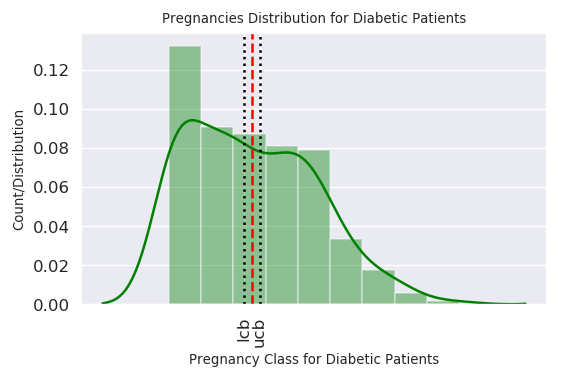

In [14]:
plt.figure(dpi=120,figsize=(5,3))
sns.distplot(df_diabetic['Pregnancies'],color='green')
plt.axvline(x=4.417756079185482,color = 'black',ls=':')
plt.axvline(x=5.313587204396608,color = 'black',ls=':')
plt.axvline(x=mean_preg_diab.best_estimate,color='red',ls='--')
plt.xticks([4.417756079185482,5.313587204396608],['lcb','ucb'],rotation=90)
plt.xlabel('Pregnancy Class for Diabetic Patients',fontdict={'fontsize':8})
plt.ylabel('Count/Distribution',fontdict={'fontsize':8})
plt.title('Pregnancies Distribution for Diabetic Patients',fontdict={'fontsize':8}) 
plt.show()

**Interpretation**

With 95% confidence, the population mean Pregnancies for all Patients with Diabetes is estimated to be
between 4.417 months and 5.314 months.

**Note** ==> See the distribution, Our Best Point Estimate is center of our confidence intervale.

# Question 2.2

**Q 2.2 : What is average month of Pregnancy for non diabetic patients?**

Population ==> All Non diabetic patients

Parameter of Interest ==> Population Mean Pregnancy Month for non diabetic patients.

**Task :** Construct a 95% C.I. for population mean Pregnancies for all non diabetic patients.

In [15]:
df_non_diabetic = df[df.Outcome=='Non-Diab']
df_non_diabetic.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,Non-Diab
3,1,89,66,23,94,28.1,0.167,21,Non-Diab
5,5,116,74,0,0,25.6,0.201,30,Non-Diab
7,10,115,0,0,0,35.3,0.134,29,Non-Diab
10,4,110,92,0,0,37.6,0.191,30,Non-Diab


In [16]:
mean_preg_non_diab = Mean(df_non_diabetic['Pregnancies'].mean(),df_non_diabetic['Pregnancies'].std(),df_non_diabetic.shape[0],1.962)

In [17]:
print("\nBest point estimate for Mean Pregnancy Month of non diabetic patients ==>", mean_preg_non_diab.best_estimate)
print("\nEstimated Standard Error for Mean Pregnancy Month of non diabetic patients ==>",mean_preg_non_diab.estimated_se)
print("\nMargin of Error for Mean Pregnancy Month of non diabetic patients ==>",mean_preg_non_diab.moe())
print("\n95% Confidence Interval for Mean Pregnancy Month of non diabetic patients ==> ",mean_preg_non_diab.mean(),"\n")


Best point estimate for Mean Pregnancy Month of non diabetic patients ==> 3.298

Estimated Standard Error for Mean Pregnancy Month of non diabetic patients ==> 0.13493259654813752

Margin of Error for Mean Pregnancy Month of non diabetic patients ==> 0.2647377544274458

95% Confidence Interval for Mean Pregnancy Month of non diabetic patients ==>  (3.0332622455725544, 3.5627377544274457) 



In [18]:
print("\n95% C.I. with statsmodels library ==>",sm.stats.DescrStatsW(df_non_diabetic['Pregnancies']).zconfint_mean())


95% C.I. with statsmodels library ==> (3.033536970425177, 3.562463029574823)


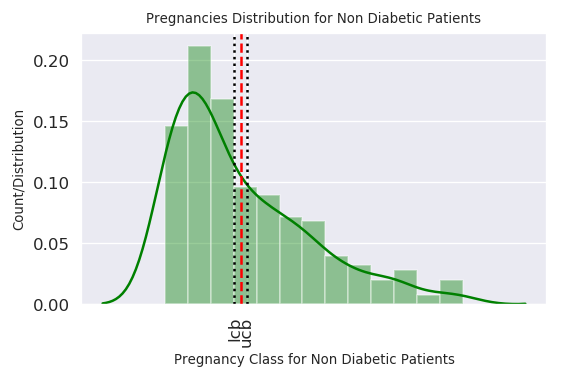

In [19]:
plt.figure(dpi=120,figsize=(5,3))
sns.distplot(df_non_diabetic['Pregnancies'],color='green')
plt.axvline(x=3.0332622455725544,color = 'black',ls=':')
plt.axvline(x=3.5627377544274457,color = 'black',ls=':')
plt.axvline(x=mean_preg_non_diab.best_estimate,color='red',ls='--')
plt.xticks([3.0332622455725544, 3.5627377544274457],['lcb','ucb'],rotation=90)
plt.xlabel('Pregnancy Class for Non Diabetic Patients',fontdict={'fontsize':8})
plt.ylabel('Count/Distribution',fontdict={'fontsize':8})
plt.title('Pregnancies Distribution for Non Diabetic Patients',fontdict={'fontsize':8}) 
plt.show()

**Interpretation**

With 95% confidence, the population mean Pregnancies for all non diabetic Patients is estimated to be
between 3.033 months and 3.562 months.

**Note** ==> See the distribution, Our Best Point Estimate is center of our confidence intervale.

# Question 2.3

**Q 2.3 : Considering Diabetic-Non Diabetic patients, do diabetic and non-diabetic patients differ significantly in mean pregnancies month?**

Population ==> Diabetic and Non-Diabetic Patients

Parameter of Interest ==> (μ1 − μ2 ): Pregnancies Month

μ1 ==> Mean pregnancies month of Diabetic Patients.

μ1 ==> Mean pregnancies month of Non-Diabetic Patients.

**There is two approach to calculate mean difference confidence interval :-**

1. Pooled Approach
2. Un-pooled approach

**Pooled Approach**
The variance of the two populations are assumed to be equal for both groups

**Unpooled Approach**
The assumption of equal variances is dropped

*Let us do some EDA to find out which approach we can use.*

In [20]:
print("\nSample Information==>")
df.groupby('Outcome').describe()['Pregnancies'].transpose().loc[['mean','std'],:]


Sample Information==>


Outcome,Diab,Non-Diab
mean,4.865672,3.298000
std,3.741239,3.017185


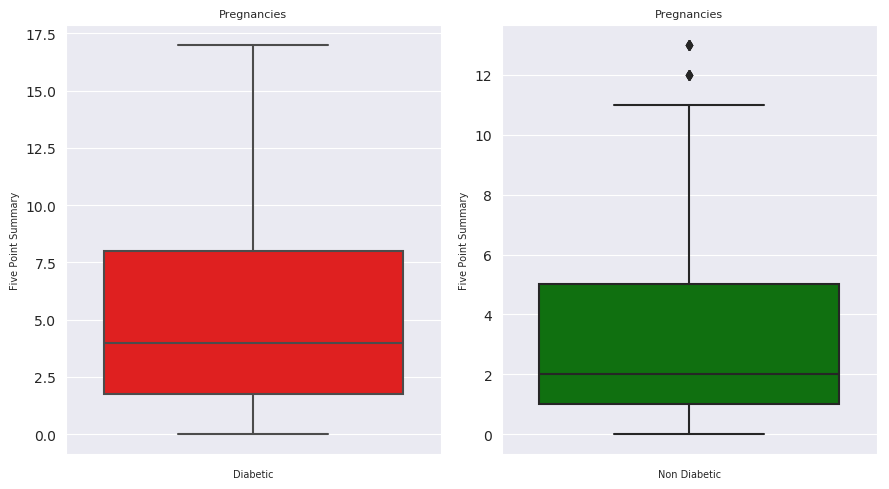

In [21]:
fig,axes = plt.subplots(nrows=1,ncols=2,dpi=100,figsize = (9,5))

plot0 = sns.boxplot(df_diabetic['Pregnancies'],ax=axes[0],orient='v',color = 'red')
axes[0].set_title('Pregnancies',fontdict={'fontsize':8})
axes[0].set_xlabel('Diabetic',fontdict={'fontsize':7})
axes[0].set_ylabel('Five Point Summary',fontdict={'fontsize':7})
plt.tight_layout()

plot1 = sns.boxplot(df_non_diabetic['Pregnancies'],ax=axes[1],orient='v',color='green')
axes[1].set_title('Pregnancies',fontdict={'fontsize':8})
axes[1].set_xlabel('Non Diabetic',fontdict={'fontsize':7})
axes[1].set_ylabel('Five Point Summary',fontdict={'fontsize':7})
plt.tight_layout()


**Variance of both diabetic and non diabetic patients are nearly similar or IQR is also almost same. Thus we can proceed with Pooled approach.**

In [22]:
x1 = df_diabetic.Pregnancies.mean()
x2 = df_non_diabetic.Pregnancies.mean()
std1 = df_diabetic.Pregnancies.std()
std2 = df_non_diabetic.Pregnancies.std()
n1 = df_diabetic.shape[0]
n2 = df_non_diabetic.shape[0]

In [23]:
mean_diff_preg = diffMean(x1,x2,std1,std2,n1,n2,1.98)

In [24]:
mean_diff_preg.pooledMean()


print("\nBest point estimate for (μ1 − μ2 ): Pregnancies Month ==>", (mean_diff_preg.best_estimate1-mean_diff_preg.best_estimate2))
print("\nEstimated Standard Error for (μ1 − μ2 ): Pregnancies Month ==>",mean_diff_preg.pooled_estimated_se)
print("\nMargin of Error for (μ1 − μ2 ): Pregnancies Month ==>",mean_diff_preg.pooledMoe())
print("\n95% Confidence Interval for (μ1 − μ2 ): Pregnancies Month ==> ",mean_diff_preg.pooledMean(),"\n")


Best point estimate for (μ1 − μ2 ): Pregnancies Month ==> 1.567671641791045

Estimated Standard Error for (μ1 − μ2 ): Pregnancies Month ==> 0.4988975585853227

Margin of Error for (μ1 − μ2 ): Pregnancies Month ==> 0.987817165998939

95% Confidence Interval for (μ1 − μ2 ): Pregnancies Month ==>  (0.579854475792106, 2.5554888077899838) 



**Interpretation**

With 95% confidence, **the difference in mean Pregnancies Month between diabetic and non-diabetic patients** is estimated to be between 0.5798 month and 2.5554 month.

# Question 2.4

**Q 2.4 : Considering Diabetic-Non Diabetic patients, do diabetic patients have higher mean pregnancies month than Non Diabetic Patients?**

Population ==> Diabetic and Non-Diabetic Patients

Parameter of Interest ==> (μ1 − μ2 ): Pregnancies Month

**Task:** Perform an independent samples test regarding the value for the difference in mean Pregnancy Month between Diabetic and Non Diabetic Patients.

μ1 ==> Mean pregnancies month of Diabetic Patients.

μ1 ==> Mean pregnancies month of Non-Diabetic Patients.

**Null:** There is no difference in mean Pregnancy Month

**Alternative:** There is a significant difference in mean Pregnancy Month

Significance Level = 5%

In [25]:
import statsmodels.api as sm

In [26]:
z,p_value = sm.stats.ztest(df_diabetic['Pregnancies'],df_non_diabetic['Pregnancies'])

print("P-Value is ==> ",p_value)

P-Value is ==>  3.006743856829293e-10


Our p-value is smaller than the 0.05 significance level, which means there is strong evidence against the null.

Thus, we reject the null!

Based on our estimated difference in sample means, **we support that there is a significant difference** between
the population mean Pregnancy month for diabetic and non diabetic patients.

**Thank you for reading this notebook. Please upvote it, if it is useful for you in anyway**

**You may also look to other part of this Notebook**

**Read First Notebook** [Univariate Analysis](https://www.kaggle.com/ravichaubey1506/univariate-statistical-analysis-on-diabetes)

**Read Second Notebook** [Multivariate Statistical Analysis](https://www.kaggle.com/ravichaubey1506/multivariate-statistical-analysis-on-diabetes)

**Read Forth Notebook** [Predective Modelling on Diabetes](https://www.kaggle.com/ravichaubey1506/predictive-modelling-knn-ann-xgboost)